# Walmart sales prediction

#### March 23, 2019
#### Luis Da Silva
This notebook builds upon the process made by the "EDA and cleaning" notebook to predict sales with a range of different methods.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from joblib import dump, load
from itertools import product

from statsmodels.tsa.stattools import adfuller
from scipy.stats import mode

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, ElasticNetCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from keras.layers.core import Activation, Dense, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping

from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

Using TensorFlow backend.


In [2]:
def wmae(holiday, y, y_pred):
    """Computes weighted mean absolute error"""
    w = holiday*4 + 1
    return -1 * (1 / w.sum()) * (w @ abs(y-y_pred))

In [3]:
def train_test_split(X, y, dates, cut_date=None, subset=None, n=5):
    '''Splits a dataset into test and train given a date'''
    if subset is None:
        subset = X.columns
    
    if cut_date is None:
        cut_date = get_cut_date(dates, n)
    
    train_index = dates < cut_date
    test_index = dates >= cut_date
    
    X_train, X_test = X[subset][train_index], X[subset][test_index]
    y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test, y_train, y_test, test_index

In [4]:
def splitter(dates, n=4):
    '''Yields train and test indices given a time variable'''
    cut_dates = get_dates(dates, n)
    for i in range(len(cut_dates)-1):
        train_idx = dates < cut_dates[i]
        test_idx = np.logical_and(~train_idx, dates<cut_dates[i+1])
        yield (train_idx, test_idx)

In [5]:
def get_cut_date(dates, n):
    '''Returns the 100/n percentile date'''
    udates = np.unique(dates)
    udates.sort()
    ndates = udates.shape[0]
    cut_date = udates[-int(ndates/n)]
    return cut_date

In [6]:
def scaler(X_train, X_test, y_train, y_test, feature_range=(-1,1), minmax=True):
    '''Scales variables'''
    if minmax:
        scalery = MinMaxScaler(feature_range=feature_range)
        scalerX = MinMaxScaler(feature_range=feature_range)
    else:
        scalerX = StandardScaler()
        scalery = StandardScaler()
    
    X_train = scalerX.fit_transform(X_train)
    X_test = scalerX.transform(X_test)

    y_train = scalery.fit_transform(pd.DataFrame(y_train))
    y_test = scalery.transform(pd.DataFrame(y_test))
    
    return X_train, X_test, y_train, y_test, scalerX, scalery

In [7]:
def cv_score(model, X, y, subset, dates=None, cut_date=None, 
             cv=4, scale=False, feature_range=(-1,1), minmax=True):
    '''Cross Validation procedure'''
    score = []
    results = {}
    
    X_train, X_test, y_train, y_test, test_index = train_test_split(X, y, dates=dates, 
                                                                        cut_date=cut_date,
                                                                        subset=subset, n=cv)
    
    if scale:
        X_train, X_test, y_train, _, scalerX, scalery = scaler(X_train, X_test, y_train, y_test, 
                                                               feature_range, minmax)
        results['scalerX'] = scalerX
        results['scalery'] = scalery
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if scale:
        y_pred = scalery.inverse_transform(y_pred)
    
    score.append(wmae(X['IsHoliday_weight'][test_index], y_test, y_pred))
    results['score'] = np.mean(score)
    results['test'] = y_test
    results['pred'] = y_pred
    results['test_idx'] = test_index
    return results

In [8]:
def fw_cv_selection(X, y, model, scale=False, stopping=None, min_decrease=0, 
                    verbose=True, cut_date=None):
    """
    Helper function to perform forward selection
    """
    if verbose:
        print("Initializing forward selection process...")
        itime = datetime.datetime.now()
    if min_decrease >= 1:
        min_decrease /= 100

    no_update = 0

    all_features = list(X.columns)
    selected_features = []
    all_first = True
    
    for r in range(len(all_features)):
        rtime = datetime.datetime.now()
        untested_features = [f for f in all_features if f not in selected_features]
        first = True

        for f1 in untested_features:
            features = selected_features + [f1]
            results = cv_score(model, X, y, features, dates, cut_date=cut_date, scale=scale)
            if first:
                first = False
                best_score_this_round = results['score']
                best_feature_this_round = f1
                if all_first:
                    all_first = False
                    best_features = features
                    best_results = results
            elif results['score'] > best_score_this_round * (1+min_decrease):
                best_score_this_round = results['score']
                best_feature_this_round = f1
                if results['score'] > best_results['score']:
                    best_features = features
                    best_results = results
                    no_update = -1
        no_update += 1
        
        # Stop searching if has been A rounds without updating
        if stopping is not None and no_update >= stopping:
            if verbose:
                print('Searching stopped on round {} after {} rounds without updating best subset.'.format(r+1,stopping))
            break
        
        if verbose:
            time_dif = datetime.datetime.now() - itime
            r_dif = datetime.datetime.now() - rtime
            t_pred = time_dif / (r+1) * len(all_features)
            print("Round {} completed in {} ({} total, {} predicted).\n{} features selected so far with score {}.".\
                  format(r+1, r_dif, time_dif, t_pred, len(best_features),best_results['score']))

        selected_features.append(best_feature_this_round)

    return results, best_features

In [9]:
def stationarity(X, verbose = True):
    '''Calculates stationarity measures'''
    result = adfuller(X.values)
    if verbose:
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
    return result

In [10]:
def read_clean_df(train=True):
    if train:
        path = '../data/merged_train_data.csv'
    else:
        path = '../data/merged_test_data.csv'
        
    df = pd.read_csv(path).iloc[:,1:]
    df.rename(index=str, columns={'Size (sq ft)':'Size'}, inplace=True)
    df.drop(['Date-1', 'Date-2', 'Promotion17', 'Promotion114',
             'Promotion121', 'Year', 'HighPromoter1', 'LowPromoter1',
             'HighPromoter2', 'LowPromoter2', 'HighPromoter3',
             'LowPromoter3', 'HighPromoter4', 'LowPromoter4',
             'HighPromoter5', 'LowPromoter5',], axis=1, inplace=True)
    if train:
        df.drop(['ImportantHoliday'], axis=1, inplace=True)
        df.loc[df['Weekly_Sales'] < 0, 'Weekly_Sales'] = 0
    
    df['Date'] = pd.to_datetime(df['Date'])
    df['IsHoliday_weight'] = df['IsHoliday']
    df['AllDept'] = df['Dept']
    df = pd.get_dummies(df, columns=['Type', 'Dept'])
    df.sort_values(['Date', 'Store', 'AllDept'], inplace=True)
    
    if train:
        # Very low weekly sales will be replaced by 0s
        threshold = df.groupby(['Store', 'AllDept'])['Weekly_Sales'].mean()/50
        for idx, v in zip(threshold.index, threshold):
            mask = np.logical_and(df['Store']==idx[0], df['AllDept']==idx[1])
            mask = np.logical_and(mask, df['Weekly_Sales']<=v)
            df.loc[mask, 'Weekly_Sales'] = 0
    return df

In [11]:
def get_dates(dates, n=4):
    udates = np.unique(dates)
    udates.sort()
    ndates = udates.shape[0]
    idxs = [int((1/(n+1))*i*ndates)-1 for i in range(1, n+2)]
    return udates[idxs]

In [12]:
def add_ARIMA_features(data, p, d, q, group=['Store', 'AllDept'], 
                       target='Weekly_Sales', drop=True, X_predict=False):
    '''Adds ARIMA features to a dataset'''
    dropx = ['Date', 'Store', 'Weekly_Sales']
    added = []
    
    # Add I:
    if d > 0:
        data['I{}'.format(d)] = data[target] - data.groupby(group)[target].shift(d)
        target = 'I{}'.format(d)
        dropx += [target]
        added.append('I{}'.format(d))
    
    # Add AR:
    for i in range(1, p+1):
        data['AR{}'.format(i)] = data.groupby(group)[target].shift(i).values
        added.append('AR{}'.format(i))
    
    # Add MA:
    for i in range(1, q+1):
        data.sort_values(group + ['Date'], inplace=True)
        data['__t__'] = data.groupby(group)[target].rolling(i).mean().values
        data['MA{}'.format(i)] = data.groupby(group)['__t__'].shift(1)
        data.drop('__t__', axis=1, inplace=True)
        added.append('MA{}'.format(i))
        
    dates = data.dropna()['Date']
    X = data.dropna().drop(dropx, axis=1)
    y = data.dropna()[target]
    drop_idx = data.isnull().sum(axis=1) == 0
    
    if X_predict:
        ynull = data[target].isnull()
        X_predict = data[ynull].drop(dropx, axis=1)
        if drop:
            data.drop(added, axis=1, inplace=True)
        return X, y, dates, drop_idx, X_predict
    
    if drop:
        data.drop(added, axis=1, inplace=True)
        
    return X, y, dates, drop_idx

In [13]:
df = read_clean_df()
df.head()

Store       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1 2010-02-05      24924.50      False        42.31       2.572   
1      1 2010-02-05      50605.27      False        42.31       2.572   
2      1 2010-02-05      13740.12      False        42.31       2.572   
3      1 2010-02-05      39954.04      False        42.31       2.572   
4      1 2010-02-05      32229.38      False        42.31       2.572   

    Promotion1  Promotion2  Promotion3   Promotion4   ...     Dept_90  \
0  9539.187953   2077.0114    1.854133  45696.30755   ...           0   
1  9539.187953   2077.0114    1.854133  45696.30755   ...           0   
2  9539.187953   2077.0114    1.854133  45696.30755   ...           0   
3  9539.187953   2077.0114    1.854133  45696.30755   ...           0   
4  9539.187953   2077.0114    1.854133  45696.30755   ...           0   

   Dept_91  Dept_92  Dept_93  Dept_94  Dept_95  Dept_96  Dept_97  Dept_98  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   Dept_99  
0        0  
1        0  
2        0  
3        0  
4        0  

[5 rows x 226 columns]

In [14]:
tdf = read_clean_df(False)

In [15]:
# In general, the series is stationary
stationarity(df.groupby('Date').mean()['Weekly_Sales'])

ADF Statistic: -5.930840
p-value: 0.000000
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


In [138]:
# Per store and department, series doesn't seem to be stationary
pvalues = []
statistic = []
for store in df['Store'].unique():
    smask = df['Store']==store
    for dept in df[smask]['AllDept'].unique():
        mask = np.logical_and(smask, df['AllDept']==dept)
        if mask.sum() < 100:
            continue
        try:
            result = stationarity(df[mask]['Weekly_Sales'], False)
            statistic.append(result[0])
            pvalues.append(result[1])
        except ValueError:
            continue

statistic = np.array(statistic)[~np.isnan(statistic)]
pvalues = np.array(pvalues)[~np.isnan(pvalues)]
print('ADF Statistic mean: {:.2f}'.format(np.mean(statistic)))
print('ADF Statistic std: {:.2f}'.format(np.std(statistic)))
print('p-value mean: {:.5f}'.format(np.mean(pvalues)))
print('p-value std: {:.5f}'.format(np.std(pvalues)))

ADF Statistic mean: -4.19
ADF Statistic std: 1.98
p-value mean: 0.08662
p-value std: 0.18463


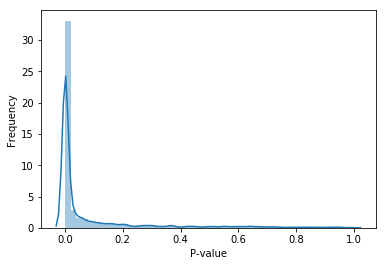

In [140]:
sns.distplot(pvalues)
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.savefig('../graphs/pvalues.png')
plt.show()

In [143]:
np.percentile(pvalues,(5, 90, 94, 95, 97.5, 99))

array([5.00320959e-12, 3.21562184e-01, 5.13022520e-01, 5.62875999e-01,
       6.91454127e-01, 8.47557261e-01])

In [15]:
def add_last_year_sales(df):
    df['LastYearDate'] = df['Date']-datetime.timedelta(weeks=52)
    df = df.merge(df[['Date', 'Weekly_Sales', 'Store', 'AllDept']], 
                  left_on=['LastYearDate', 'Store', 'AllDept'], 
                  right_on=['Date','Store', 'AllDept'], how='left')
    df.rename(index=str, columns={'Weekly_Sales_y':'LastYearSales',
                                  'Weekly_Sales_x':'Weekly_Sales',
                                  'Date_x':'Date'}, inplace=True)
    df.drop(['LastYearDate', 'Date_y'], axis=1, inplace=True)
    return df

In [16]:
df = add_last_year_sales(df)

In [32]:
columns = list(df.columns)
columns

['Store',
 'Date',
 'Weekly_Sales',
 'IsHoliday',
 'Temperature',
 'Fuel_Price',
 'Promotion1',
 'Promotion2',
 'Promotion3',
 'Promotion4',
 'Promotion5',
 'CPI',
 'Unemployment',
 'Superbowl',
 'Superbowl_l7',
 'Superbowl_l14',
 'Superbowl_l-7',
 'Labor',
 'Labor_l7',
 'Labor_l14',
 'Labor_l-7',
 'ThanksGiving',
 'ThanksGiving_l7',
 'ThanksGiving_l14',
 'ThanksGiving_l-7',
 'Christmas',
 'Christmas_l7',
 'Christmas_l14',
 'Christmas_l-7',
 'Day',
 'Store_1',
 'Store_2',
 'Store_3',
 'Store_4',
 'Store_5',
 'Store_6',
 'Store_7',
 'Store_8',
 'Store_9',
 'Store_10',
 'Store_11',
 'Store_12',
 'Store_13',
 'Store_14',
 'Store_15',
 'Store_16',
 'Store_17',
 'Store_18',
 'Store_19',
 'Store_20',
 'Store_21',
 'Store_22',
 'Store_23',
 'Store_24',
 'Store_25',
 'Store_26',
 'Store_27',
 'Store_28',
 'Store_29',
 'Store_30',
 'Store_31',
 'Store_32',
 'Store_33',
 'Store_34',
 'Store_35',
 'Store_36',
 'Store_37',
 'Store_38',
 'Store_39',
 'Store_40',
 'Store_41',
 'Store_42',
 'Store_43

In [17]:
# Adding seasonality
dates = df.dropna()['Date']
cut_date = get_cut_date(dates, 5)
df['week'] = df.Date.dt.week
seasonality = df[df['Date']<cut_date].groupby(['Store', 'AllDept', 'week'])[['Weekly_Sales']].mean()
seasonality.columns = ['Seasonality']
seasonality.reset_index(inplace=True)
seasonality['Seasonality'] = seasonality['Seasonality'] - seasonality.groupby(['Store', 'AllDept'])['Seasonality'].shift(1)
seasonality.fillna(0, inplace=True)
df = df.merge(seasonality, on=['Store', 'AllDept', 'week'])

Text(0, 0.5, 'Change in Sales')

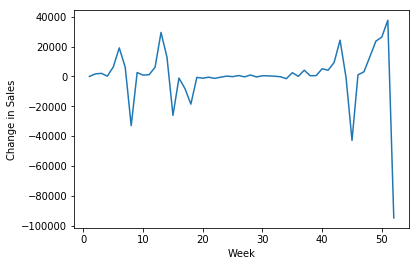

In [63]:
mask = np.logical_and(seasonality['Store']==10, seasonality['AllDept']==1)
plt.plot(range(1, mask.sum() + 1), seasonality[mask]['Seasonality'])
plt.xlabel('Week')
plt.ylabel('Change in Sales')

# LASSO with ARIMA/ARMA and STLF

In [63]:
best_pdq = (0, 0, 0)
best_score = -1e99
init = datetime.datetime.now()
p = 20
q = 10
for d in (0, 1):
    pdq = (p, d, q)
    X, y, dates, drop_idx = add_ARIMA_features(df, p, d, q)
    tscv = splitter(dates)
    lasso = LassoCV(cv=tscv, n_alphas=1000).fit(X, y)
    features = [name for coef,name in zip(lasso.coef_, X.columns) if not np.isclose(coef, 0)]
    lasso_alpha = lasso.alpha_
    lasso = Lasso(alpha=lasso_alpha)
    lasso_r = cv_score(lasso, X, y, features, dates=dates, cut_date='2011-11-02')

    if lasso_r['score'] > best_score:
        best_pdq = pdq
        best_score = lasso_r['score']
        best_features = features
        best_preds = lasso_r['pred']

    print('*--'*30)
    print(pdq)
    print('Score: {}, Alpha: {}, Features: {}.'.format(lasso_r['score'], lasso_alpha, features))
    diff = datetime.datetime.now() - init
    print('Time: {}'.format(diff))

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
(20, 0, 10)
Score: -1441.7917551338603, Alpha: 548022.3646672769, Features: ['Promotion3', 'LastYearSales', 'Seasonality', 'AR1', 'AR2', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR11', 'AR13', 'AR15', 'AR16', 'AR17', 'AR18'].
Time: 0:02:20.184066


In [24]:
lasso_features = features
subdf = df[['Store', 'AllDept', 'Date']][drop_idx][lasso_r['test_idx']]
subdf['pred'] = lasso_r['pred']
subdf['test'] = lasso_r['test']

[]

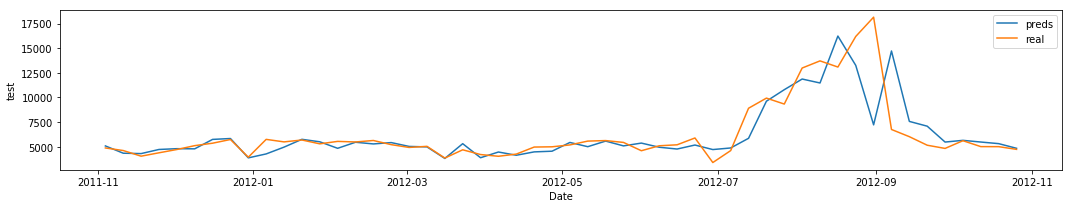

In [25]:
plt.figure(figsize=(15,3))
mask = np.logical_and(subdf['Store']==3, subdf['AllDept']==3)
sns.lineplot(data = subdf[mask], x='Date', y='pred', label='preds')
sns.lineplot(data = subdf[mask], x='Date', y='test', label='real')
plt.legend()
plt.tight_layout()
plt.plot()

# Elastic Net with ARIMA/ARMA and STLF

In [122]:
init = datetime.datetime.now()
p = 20
q = 10
for d in (0, 1):
    pdq = (p, d, q)
    X, y, dates, drop_idx = add_ARIMA_features(df, p, d, q)
    tscv = splitter(dates)
    elastic = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=tscv).fit(X, y)
    features = [name for coef,name in zip(elastic.coef_, X.columns) if not np.isclose(coef, 0)]
    alpha = elastic.alpha_
    l1_ratio = elastic.l1_ratio_
    elastic = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    elastic_r = cv_score(elastic, X, y, features, dates=dates, cut_date='2011-11-02')

    if elastic_r['score'] > best_score:
        best_pdq = pdq
        best_score = elastic_r['score']
        best_features = features
        best_preds = elastic_r['pred']
        print('New Elastic Best Score!')

    print(pdq)
    print('Score: {}, Alpha: {}, L1: {}, Features: {}.'.format(elastic_r['score'], alpha, l1_ratio, features))
    diff = datetime.datetime.now() - init
    print('Time: {}'.format(diff))
    print('*--'*30)

(20, 0, 10)
Score: -15657.32708747224, Alpha: 540835.6070570898, L1: 1.0, Features: ['Promotion3', 'LastYearSales', 'Seasonality', 'AR1', 'AR2', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR11', 'AR13', 'AR15', 'AR16', 'AR17', 'AR18'].
Time: 0:02:25.796056
*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--


In [50]:
elastic_features = features
subdf = df[['Store', 'AllDept', 'Date']][drop_idx][elastic_r['test_idx']]
subdf['pred'] = elastic_r['pred']
subdf['test'] = elastic_r['test']

[]

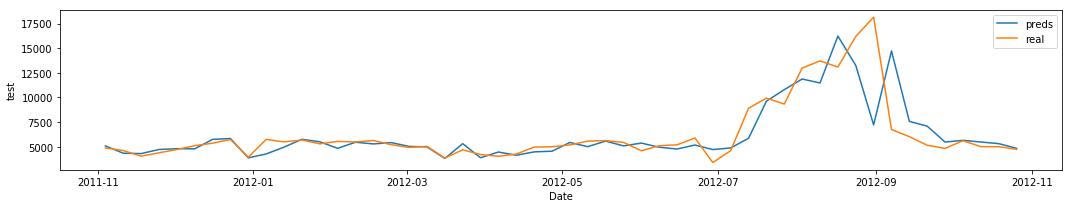

In [51]:
plt.figure(figsize=(15,3))
mask = np.logical_and(subdf['Store']==3, subdf['AllDept']==3)
sns.lineplot(data = subdf[mask], x='Date', y='pred', label='preds')
sns.lineplot(data = subdf[mask], x='Date', y='test', label='real')
plt.legend()
plt.tight_layout()
plt.plot()

# Forward Selection with Linear Model

In [78]:
lm = LinearRegression()
results_lm, best_features_lm = fw_cv_selection(X, y, lm, scale=False, stopping=4,
                                               min_decrease=0.01, cut_date='2011-11-02')
print('Score: {}, Features: {}.'.format(results_lm['score'], best_features_lm))

Initializing forward selection process...
Round 1 completed in 0:00:10.843962 (0:00:10.843962 total, 0:46:16.054272 predicted).
1 features selected so far with score -2016.37698693574.
Round 2 completed in 0:00:12.135542 (0:00:22.979504 total, 0:49:01.376512 predicted).
2 features selected so far with score -1950.7461501148834.
Round 3 completed in 0:00:14.604938 (0:00:37.584442 total, 0:53:27.205632 predicted).
2 features selected so far with score -1950.7461501148834.
Round 4 completed in 0:00:15.201343 (0:00:52.786781 total, 0:56:18.353920 predicted).
2 features selected so far with score -1950.7461501148834.
Round 5 completed in 0:00:17.075332 (0:01:09.863110 total, 0:59:36.991232 predicted).
2 features selected so far with score -1950.7461501148834.
Round 6 completed in 0:00:19.060021 (0:01:28.924129 total, 1:03:14.096128 predicted).
6 features selected so far with score -1937.3522162596794.
Round 7 completed in 0:00:21.365855 (0:01:50.289984 total, 1:07:13.462272 predicted).
7 fe

In [27]:
best_features_lm

['LastYearSales', 'MA10', 'MA9', 'MA8', 'MA7', 'Seasonality', 'MA1', 'AR5']

In [28]:
subdf = df[['Store', 'AllDept', 'Date']][drop_idx][results_lm['test_idx']]
subdf['pred'] = results_lm['pred']
subdf['test'] = results_lm['test']

[]

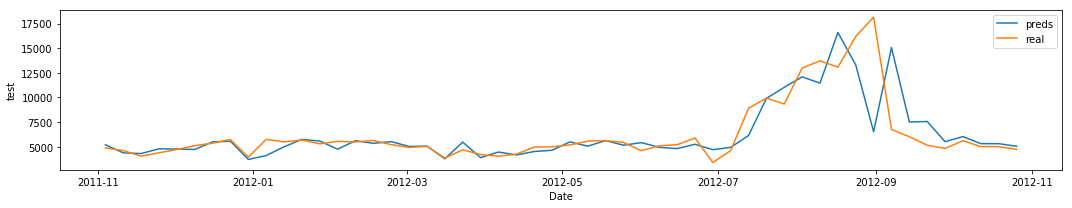

In [29]:
plt.figure(figsize=(15,3))
mask = np.logical_and(subdf['Store']==3, subdf['AllDept']==3)
sns.lineplot(data = subdf[mask], x='Date', y='pred', label='preds')
sns.lineplot(data = subdf[mask], x='Date', y='test', label='real')
plt.legend()
plt.tight_layout()
plt.plot()

# Random Forest

In [79]:
rf = RandomForestRegressor(n_estimators=100, min_impurity_decrease=0.001, max_depth=None)
#param_grid = {'max_depth':[8, 16, 32, None]}
rf_r = cv_score(rf, X, y, best_features_lm, dates, cv=4, cut_date='2011-11-02')
rf_r['score']

-1722.304064803418

In [86]:
subdf = df[['Store', 'AllDept', 'Date']][drop_idx][rf_r['test_idx']]
subdf['pred'] = rf_r['pred']
subdf['test'] = rf_r['test']

[]

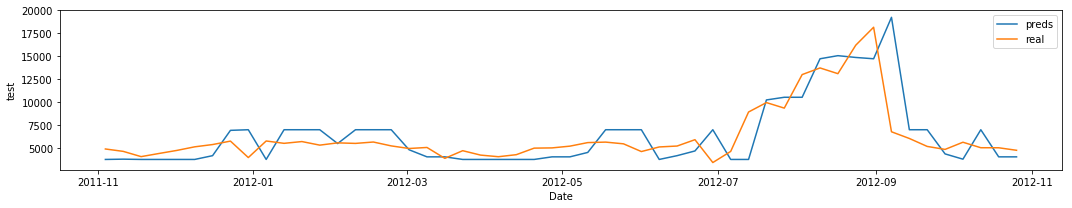

In [87]:
plt.figure(figsize=(15,3))
mask = np.logical_and(subdf['Store']==3, subdf['AllDept']==3)
sns.lineplot(data = subdf[mask], x='Date', y='pred', label='preds')
sns.lineplot(data = subdf[mask], x='Date', y='test', label='real')
plt.legend()
plt.tight_layout()
plt.plot()

# MLP

In [84]:
mlp = MLPRegressor(hidden_layer_sizes=(200, 10), verbose=True)
mlp_r = cv_score(mlp, X, y, features, dates, scale=True, minmax=False, cut_date='2011-11-02')
mlp_r['score']

Iteration 1, loss = 0.02067206
Iteration 2, loss = 0.00500015
Iteration 3, loss = 0.00438079
Iteration 4, loss = 0.00420093
Iteration 5, loss = 0.00422993
Iteration 6, loss = 0.00407917
Iteration 7, loss = 0.00400466
Iteration 8, loss = 0.00399755
Iteration 9, loss = 0.00384473
Iteration 10, loss = 0.00371814
Iteration 11, loss = 0.00366701
Iteration 12, loss = 0.00370906
Iteration 13, loss = 0.00366150
Iteration 14, loss = 0.00359068
Iteration 15, loss = 0.00361575
Iteration 16, loss = 0.00352294
Iteration 17, loss = 0.00350762
Iteration 18, loss = 0.00346241
Iteration 19, loss = 0.00338444
Iteration 20, loss = 0.00342627
Iteration 21, loss = 0.00341756
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


-2037.1706567288868

[]

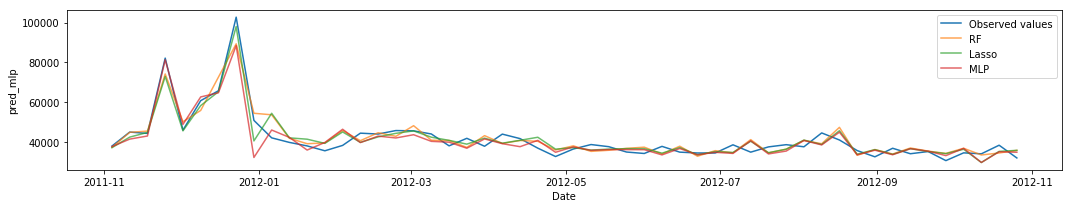

In [90]:
subdf = df[['Store', 'AllDept', 'Date']][drop_idx][lasso_r['test_idx']]
subdf['pred'] = rf_r['pred']
subdf['test'] = rf_r['test']
subdf['pred_lasso'] = lasso_r['pred']
subdf['pred_mlp'] = mlp_r['pred']
subdf['pred_linear'] = results_lm['pred']

plt.figure(figsize=(15,3))
s=10
d=14
mask = np.logical_and(subdf['Store']==s, subdf['AllDept']==d)
sns.lineplot(data = subdf[mask], x='Date', y='test', label='Observed values')
sns.lineplot(data = subdf[mask], x='Date', y='pred', label='RF', alpha=0.7)
sns.lineplot(data = subdf[mask], x='Date', y='pred_lasso', label='Lasso', alpha=0.7)
sns.lineplot(data = subdf[mask], x='Date', y='pred_mlp', label='MLP', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('../graphs/hoPreds{}_{}.png'.format(s,d))
plt.plot()

In [146]:
# Averaging everything
subdf['avg'] = subdf[['pred', 'pred_lasso', 'pred_mlp', 'pred_linear']].mean(axis=1)
holi = X['IsHoliday_weight'][rf_r['test_idx']]
wmae(holi, subdf['test'], subdf['avg'])

-1422.3397397491399

# LSTM

In [52]:
def build_lstm(neurons):
    model = Sequential()
    model.add(LSTM(neurons, stateful=False))
    model.add(Dense(int(np.sqrt(neurons))))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def fit_lstm(model, X_train, X_test, y_train, y_test, batch_size, nb_epoch, weights=None, verbose=0):
    X_train = X_train.reshape(int(X_train.shape[0]/batch_size), batch_size, X_train.shape[1])
    X_test = X_test.reshape(int(X_test.shape[0]/batch_size), batch_size, X_test.shape[1])
    y_train = y_train.reshape(int(y_train.shape[0]/batch_size), batch_size)
    y_test = y_test.reshape(int(y_test.shape[0]/batch_size), batch_size)
    
    es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=40, verbose=verbose, restore_best_weights=True)
    
    if weights is not None:
        model.set_weights(weights)
    
    history = model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size, callbacks=[es],
                        verbose=verbose, shuffle=False, validation_data=(X_test, y_test))
    return model, history

In [12]:
# Clean departments with wrong data
var_list = ['IsHoliday', 'Temperature','Fuel_Price', 'Promotion1',
            'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'CPI', 'Unemployment', 'Superbowl',
            'Labor', 'ThanksGiving', 'Christmas', 'Weekly_Sales', 'Store', 'AllDept', 'Date']
df = df[var_list].dropna()
tdf = tdf[[i for i in var_list if i != 'Weekly_Sales']]

In [14]:
var_list = [i for i in var_list if i not in ['Weekly_Sales', 'Store', 'AllDept', 'Date']]
mask = np.logical_and(df['Store']==1, df['AllDept']==1)
indX = df[mask][var_list]
indy = df[mask]['Weekly_Sales']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(indX, indy)
X_train, X_test, y_train, y_test, scalerX, scalery = scale(X_train, X_test, y_train, y_test, (-1, 1))

In [53]:
lstm = build_lstm(1000)

In [19]:
lstm, history = fit_lstm(lstm, X_train, X_test, y_train, y_test, 1, 2000, verbose=1)

Train on 115 samples, validate on 28 samples
Epoch 1/2000
115/115 [==============================] - 1s 11ms/step - loss: 0.2245 - val_loss: 0.0803
Epoch 2/2000
115/115 [==============================] - 1s 10ms/step - loss: 0.2146 - val_loss: 0.0947
Epoch 3/2000
115/115 [==============================] - 1s 9ms/step - loss: 0.2254 - val_loss: 0.1040
Epoch 4/2000
115/115 [==============================] - 1s 8ms/step - loss: 0.2158 - val_loss: 0.1088
Epoch 5/2000
115/115 [==============================] - 1s 8ms/step - loss: 0.2085 - val_loss: 0.1053
Epoch 6/2000
115/115 [==============================] - 1s 8ms/step - loss: 0.2080 - val_loss: 0.1338
Epoch 7/2000
115/115 [==============================] - 1s 8ms/step - loss: 0.1978 - val_loss: 0.1265
Epoch 8/2000
115/115 [==============================] - 1s 9ms/step - loss: 0.1895 - val_loss: 0.1177
Epoch 9/2000
115/115 [==============================] - 1s 9ms/step - loss: 0.1935 - val_loss: 0.1109
Epoch 10/2000
115/115 [============

In [20]:
np.array(history.history['val_loss']).min()

0.08031270571310804

In [22]:
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40)                8800      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 9,641
Trainable params: 9,641
Non-trainable params: 0
_________________________________________________________________


In [54]:
done = []
preds = {'store':[], 'department':[], 'date':[], 'preds':[], 'real':[]}
future = {'store':[], 'department':[], 'date':[], 'preds':[]}

In [97]:
preds = load('../models/lstm/LSTM_preds.joblib')
future = load('../models/lstm/LSTM_future.joblib')

In [51]:
done = (pd.DataFrame(preds)[['store', 'department']].drop_duplicates())
done = [tuple(done.iloc[i]) for i in range(done.shape[0])]

In [55]:
ini_time = datetime.datetime.now()
i = 0
for store in df['Store'].unique():
    mask_s = df['Store'] == store
    mask_test = tdf['Store'] == store
    for department in df[mask_s]['AllDept'].unique():
        i+=1
        if (store, department) in done:
            continue
        # Get dataset selection
        mask = np.logical_and(mask_s, df['AllDept']==department)
        indX = df[mask][var_list]
        indy = df[mask]['Weekly_Sales']
        
        if indX.shape[0] < 52:
            # Too few observations
            continue
        
        X_train, X_test, y_train, y_test = train_test_split(indX, indy)
        X_train, X_test, y_train, y_test, scalerX, scalery = scale(X_train, X_test, y_train, y_test, (-1, 1))
        dates = df[mask]['Date'][-y_test.shape[0]:]
        
        # Train lstm
        lstm, _ = fit_lstm(lstm, X_train, X_test, y_train, y_test, 1, 2000, weights=lstm.get_weights(), verbose=0)
        
        # Make predictions
        pred_y = scalery.inverse_transform(lstm.predict(X_test.reshape(X_test.shape[0], 1, X_test.shape[1])))
        y_test = scalery.inverse_transform(y_test)
        for pred, ys, date in zip(pred_y, y_test, dates):
            preds['store'].append(store)
            preds['department'].append(department)
            preds['date'].append(date)
            preds['preds'].append(pred[0])
            preds['real'].append(ys[0])
            
        # Future test data
        mask = np.logical_and(mask_test, tdf['AllDept']==department)
        if mask.sum() == 0:
            continue
            
        future_X = scalerX.transform(tdf[mask][var_list])
        future_y = scalery.inverse_transform(lstm.predict(future_X.reshape(future_X.shape[0], 1, future_X.shape[1])))
        for fy, date in zip(future_y, dates):
            future['store'].append(store)
            future['department'].append(department)
            future['date'].append(date)
            future['preds'].append(fy[0])
            
        # Report progress
        diff = datetime.datetime.now() - ini_time
        print('{} stores done. Time: {}. Expected: {}.'.format(i, diff, diff*3330/i))
        break
    break
    
    # Save results
    dump(preds, '../models/LSTM_preds.joblib')
    dump(future, '../models/LSTM_future.joblib')

1 stores done. Time: 0:02:13.866180. Expected: 5 days, 3:49:34.379400.


In [53]:
dump(future, '../models/LSTM_future.joblib')
dump(preds, '../models/LSTM_preds.joblib')

['../models/LSTM_preds.joblib']

In [101]:
pred_df = pd.DataFrame(preds)
pred_df['real'] = pred_df['real'].apply(lambda x: x[0])
pred_df = pred_df.merge(df[['IsHoliday', 'Date']].drop_duplicates(), left_on='date', right_on='Date', how='left')
pred_df.head()

store  department       date         preds      real  IsHoliday       Date
0      1           1 2012-04-20  27094.335938  16976.19      False 2012-04-20
1      1           1 2012-04-27  26931.142578  16347.60      False 2012-04-27
2      1           1 2012-05-04  25047.322266  17147.44      False 2012-05-04
3      1           1 2012-05-11  25230.392578  18164.20      False 2012-05-11
4      1           1 2012-05-18  25913.714844  18517.79      False 2012-05-18

In [102]:
wmae(pred_df['IsHoliday'], pred_df['real'], pred_df['preds'])

-3046.2326904431866

[]

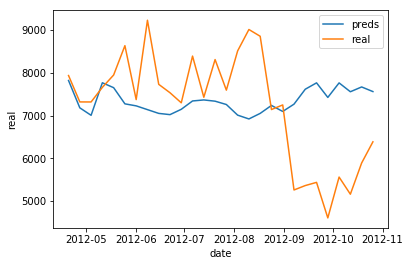

In [103]:
mask = np.logical_and(pred_df['store']==4, pred_df['department']==30)
sns.lineplot(data=pred_df[mask], y='preds', x='date', label='preds')
sns.lineplot(data=pred_df[mask], y='real', x='date', label='real')
plt.legend()
plt.plot()

# Predict Test

In [31]:
tdf.rename(columns={"Weekly_Sales to be predicted":"Weekly_Sales"}, inplace=True)
tdates = tdf.Date
tudates = np.unique(tdates)
tudates.sort()

In [32]:
lasso = Lasso(alpha=lasso_alpha)
temp = df

for i, date in enumerate(tudates):
    # Add new obs to df
    extra_date = tdf['Date'] == date
    temp = pd.concat([temp.drop('LastYearSales', axis=1), tdf[extra_date]], sort=False)
    
    # Add missing features (ARMA, seasonality and lastYearSales)
    temp['week'] = temp['Date'].dt.week
    temp = temp.drop('Seasonality', axis=1).merge(seasonality, on=['Store', 'AllDept', 'week'])
    temp = add_last_year_sales(temp)
    X, y, dates, drop_idx, X_predict = add_ARIMA_features(temp, 20, 0, 10, X_predict=True)
    
    # Fit Predict
    mask = temp[temp['Weekly_Sales'].isnull()]['Date'] == date
    lasso.fit(X[features], y)
    preds = lasso.predict(X_predict[features][mask].fillna(X_predict['AR3'][mask]).fillna(0))
        
    # Add preds to temp
    temp.loc[temp['Weekly_Sales'].isnull(), 'Weekly_Sales'] = preds 
    
    print('{} out of {}'.format(i+1, len(tudates)))

1 out of 39
2 out of 39
3 out of 39
4 out of 39
5 out of 39
6 out of 39
7 out of 39
8 out of 39
9 out of 39
10 out of 39
11 out of 39
12 out of 39
13 out of 39
14 out of 39
15 out of 39
16 out of 39
17 out of 39
18 out of 39
19 out of 39
20 out of 39
21 out of 39
22 out of 39
23 out of 39
24 out of 39
25 out of 39
26 out of 39
27 out of 39
28 out of 39
29 out of 39
30 out of 39
31 out of 39
32 out of 39
33 out of 39
34 out of 39
35 out of 39
36 out of 39
37 out of 39
38 out of 39
39 out of 39


In [37]:
mask = temp['Date']>='2012-11-02'
predicted_test = temp[mask][['Store', 'AllDept', 'Date', 'Weekly_Sales']]
predicted_test.to_csv('../data/lasso_predicted_sales.csv', index=False)

store = predicted_test['Store'].astype(int).astype(str)
dept = predicted_test['AllDept'].astype(int).astype(str)
predicted_test['Id'] = store+'_'+dept+'_'+predicted_test['Date'].astype(str)
predicted_test[['Id', 'Weekly_Sales']].to_csv('../data/lasso_submission.csv', index=False)

# Plot

In [45]:
predicted_test.shape

(113632, 5)

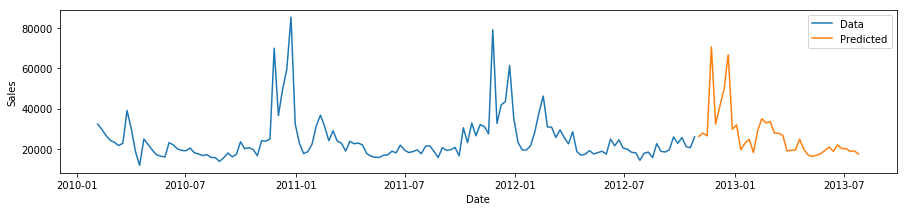

In [94]:
predictions = pd.read_csv('../data/lasso_predicted_sales.csv')
predictions.Date = pd.to_datetime(predictions.Date)
s = 1
d = 5
pmask = np.logical_and(predictions['Store'] == s, predictions['AllDept']==d)

mmask = np.logical_and(df['Store'] == s, df['AllDept']==d)

plt.figure(figsize=(15,3))
sns.lineplot(data=df[mmask], x='Date', y='Weekly_Sales', label='Data')
sns.lineplot(data=predictions[pmask], x='Date', y='Weekly_Sales', label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.savefig('../graphs/testPreds.png')
plt.show()